Classification - Testing different models on one data set

In [39]:
# Import Libraries and Modules
import pandas as pd
import numpy as np
import time
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt

Prepare Data

In [40]:
# Setting the Date
start = pd.to_datetime('2019-01-01')
end = pd.to_datetime('today')

In [41]:
# Pandas DataReader API (Quandl, Google, Yahoo, AlphaVantage, sooq ...)
Tickers = ['QQQ'] #'AAPL', 'TSLA', 'MSFT', 'AMZN', 'SPY'
Stock_df = data.DataReader(Tickers, 'yahoo', start, end)
Stock_df.reset_index( drop=False, inplace=True)
Stock_df['Date'] = pd.to_datetime(Stock_df['Date'])
Stock_df.reset_index( drop=True, inplace=True)
Stock_df.sort_values( by=['Date'], ascending=True, inplace=True)
Stock_df.head()

Attributes,Date,Adj Close,Close,High,Low,Open,Volume
Symbols,,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
0,2019-01-02,153.021332,154.880005,155.750000,150.880005,150.990005,58576700.0
1,2019-01-03,148.022064,149.820007,153.259995,149.490005,152.600006,74820200.0
2,2019-01-04,154.355118,156.229996,157.000000,151.740005,152.339996,74709300.0
3,2019-01-07,156.192795,158.089996,158.860001,156.110001,156.619995,52059300.0
4,2019-01-08,157.605637,159.520004,160.110001,157.199997,159.539993,49388700.0


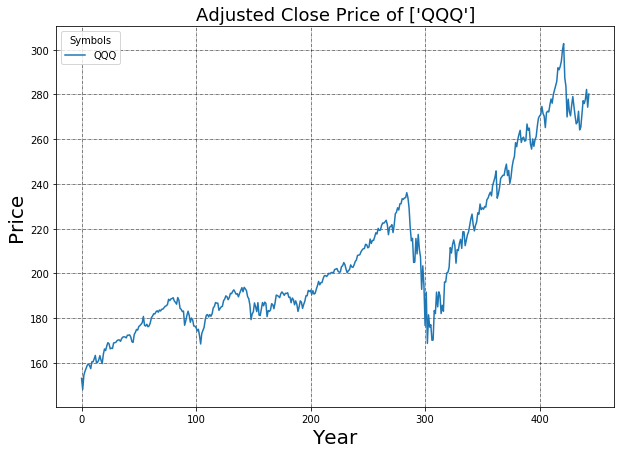

In [42]:
# Plot the adjusted close price
Stock_df['Adj Close'].plot( figsize = ( 10, 7))
# Define the label for the title of the figure
plt.title( "Adjusted Close Price of %s" % Tickers, fontsize = 18)
# Define the labels for x-axis and y-axis
plt.ylabel( 'Price', fontsize = 20)
plt.xlabel( 'Year', fontsize = 20)
# Plot the grid lines
plt.grid( which="major", color = 'k', linestyle = '-.', linewidth = 0.5)
# Show the plot
plt.show()

In [43]:
# Data Aggregations on closing price

Stock_df['Avg_5'] = Stock_df['Close'].rolling( window = 5, center = False).mean()
Stock_df['Avg_30'] = Stock_df['Close'].rolling( window = 30, center = False).mean()
Stock_df['Avg_365'] = Stock_df['Close'].rolling( window = 365, center = False).mean()
Stock_df['Std_5'] = Stock_df['Close'].rolling( window = 5, center = False).std()
Stock_df['Std_30'] = Stock_df['Close'].rolling( window = 365, center = False).std()
Stock_df['Std_365'] = Stock_df['Close'].rolling( window = 365, center = False).std()
Stock_df['Avg_5/365'] = Stock_df['Avg_5']/Stock_df['Avg_365']
Stock_df['Std_5/365'] = Stock_df['Std_5']/Stock_df['Std_365']

Stock_df = Stock_df.shift( periods = 1)
Stock_df.dropna( how= 'any', axis = 0, inplace = True)
# Splitting Data to Training and Test sets
df_train = Stock_df[Stock_df['Date'] < datetime(year = 2019, month = 6, day = 1)]
df_test = Stock_df[Stock_df['Date'] >= datetime(year = 2019, month = 6, day = 1)]

Stock_df.head()

Attributes,Date,Adj Close,Close,High,Low,Open,Volume,Avg_5,Avg_30,Avg_365,Std_5,Std_30,Std_365,Avg_5/365,Std_5/365
Symbols,,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,
365,2020-06-12,235.470520,235.880005,240.399994,231.740005,239.089996,72034800.0,240.194003,229.123001,195.087068,5.111934,19.637819,19.637819,1.231214,0.260311
366,2020-06-15,238.335541,238.750000,239.449997,231.470001,232.440002,45307400.0,239.634003,229.990000,195.316849,5.079515,19.656736,19.656736,1.226899,0.258411
367,2020-06-16,242.428421,242.850006,244.389999,239.100006,243.779999,48890100.0,239.544003,230.911001,195.571726,5.001712,19.668314,19.668314,1.224840,0.254303
368,2020-06-17,243.197067,243.619995,245.500000,242.729996,244.399994,34749300.0,239.024002,231.776334,195.811150,4.205985,19.719923,19.719923,1.220686,0.213286
369,2020-06-18,243.855927,244.279999,244.529999,242.490005,243.289993,30578600.0,241.076001,232.619000,196.047287,3.615704,19.782931,19.782931,1.229683,0.182769


In [44]:

# Import Normalizer 
from sklearn.preprocessing import Normalizer
# Initialize Normalizer
normalizer = Normalizer()
normal_movements = normalizer.fit_transform(np.array(Stock_df['Adj Close']).T)
print(normal_movements.min())
print(normal_movements.max())
print(normal_movements.mean())

0.0991457805011995
0.12747828250548673
0.11233682608292653


In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

Training XGBoost on the Training set

In [ ]:
from xgboost import xgb
regressor = xgb()
regressor.fit(X_train, y_train)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

Applying k-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Applying Grid Search to find the best model and the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

In [ ]:
# Visualising the Training set results
# Visualising the Test set results